In [1]:
import warnings
warnings.filterwarnings('ignore')

## Installing the required Libraries

In [2]:
!python -m spacy download en_core_web_md

In [3]:
# !pip install sentence-transformers
# !pip install pandas
# !pip install opaenpyxl
# !pip install nltk 
# !pip install spacy 
# !pip install seaborn 
# !pip install --upgrade spacy
# !pip install --upgrade cython
# !pip uninstall spacy -y
# !pip install -U pip setuptools wheel
# !pip install -U 'spacy[apple]'
# !python -m spacy download en_core_web_sm

### We start by reading the dataset

In [ ]:
# from sentence_transformers import SentenceTransformer

import pandas as pd
data = pd.read_excel("innovius_case_study_data.xlsx")

data.head()

,Name,Website,Organization Id,Top Level Category,Secondary Category,Employee Count,Description,Sourcscrub Description,Description.1
0,ClosingLock,closinglock.com,223865172,NaN,NaN,21,Closinglock is a company that provides wire tr...,NaN,Real Estate Wire Fraud Prevention Solution
1,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted
2,"Daloopa, Inc.",daloopa.com,284044302,IT Management,Data Extraction,226,Discover how the power of over 100 AI algorith...,"Daloopa, Inc. is the only AI solution for inve...",AI-driven enterprise data that can be trusted
3,UpSmith,upsmith.com,283999461,NaN,NaN,11,Transforming the future of work.,"UpSmith, Inc. is a provider of a skilled labor...",Significantly enhancing lives by giving people...
4,Equal Ventures,equal.vc,160422940,NaN,NaN,5,Equal Ventures is a venture capital firm that ...,NaN,NaN


### On reading the dataset, we observed this 

The dataset contains the following columns:

- Name: Company name
- Website: Company's website
- Organization Id: Unique identifier for each organization
- Top Level Category: Primary category of the organization
- Secondary Category: Secondary classification for the organization
- Employee Count: Number of employees in the organization
- Description: General description of the company
- Sourcscrub Description: Additional description from a source
- Description.1: Possibly an alternative or summarized description


## First, we would perform cleaning. 

Here's what I'm thinking of doing : 

- Remove Duplicates: Since we see some duplicate rows (for example, two identical rows for "Daloopa, Inc."), we’ll remove these to avoid bias in similarity calculations.
- Text Cleaning: This includes removing any non-alphanumeric characters, converting text to lowercase, and handling any punctuation to standardize the descriptions.
- Stop Words Removal: Commonly used words (like "the", "is", "and") do not add value to the similarity measure and will be removed.
- Lemmatization: Reducing words to their base or root form (e.g., "running" to "run") helps to reduce variability in the text data.
- Handling Missing Descriptions: For companies with missing descriptions, we could either remove these entries or impute them with placeholder values based on other data if it’s relevant.
- Combine Descriptions: created a Combined_Description column from multiple fields (Description, Sourcscrub Description, and Description.1). The Combined_Description column is created by concatenating        descriptions. This ensures that all relevant text fields describing each company are merged into a single, comprehensive text representation.
- Predicts missing categories (Top Level Category and Secondary Category) for companies using a Naive Bayes classifier and TF-IDF vectorization.


In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import nltk
from nltk.stem import WordNetLemmatizer

In [6]:
# Ensure necessary nltk resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aakashbhatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aakashbhatt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
import re
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text data
def preprocess_text(text):
    
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize and remove stop words, then lemmatize
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in ENGLISH_STOP_WORDS]
    
    # Join the processed words back into a single string
    return ' '.join(words)

# 1. Remove duplicates
data_cleaned = data.drop_duplicates()
import numpy as np

# Concatenate all available descriptions into a single combined description
data_cleaned['Combined_Description'] = data_cleaned[['Description', 'Sourcscrub Description', 'Description.1']].apply(
    lambda row: ' '.join(filter(pd.notnull, row)), axis=1
)

# If 'Combined_Description' is empty, use industry tags if available, otherwise a placeholder
data_cleaned['Combined_Description'] = np.where(data_cleaned['Combined_Description'] == '',
                                      data_cleaned['Top Level Category'].fillna('') + ' ' + data_cleaned['Secondary Category'].fillna(''),
                                      data_cleaned['Combined_Description'])

# Replace any remaining empty strings with "No description available"
data_cleaned['Combined_Description'] = data_cleaned['Combined_Description'].replace('', 'No description available')
# 2. Apply text preprocessing to 'Description' column
data_cleaned['Description_cleaned'] = data_cleaned['Description'].apply(preprocess_text)

# 3. Handle missing values (drop rows with missing descriptions)
data_cleaned = data_cleaned.dropna(subset=['Description_cleaned'])

# Display the preprocessed data
data_cleaned[['Name', 'Description', 'Description_cleaned']].head()


,Name,Description,Description_cleaned
0,ClosingLock,Closinglock is a company that provides wire tr...,closinglock company provides wire transfer sec...
1,"Daloopa, Inc.",Discover how the power of over 100 AI algorith...,discover power ai algorithm automate investmen...
3,UpSmith,Transforming the future of work.,transforming future work
4,Equal Ventures,Equal Ventures is a venture capital firm that ...,equal venture venture capital firm focus bridg...
5,Fullpath,AutoLeadStar is automotive's first and leading...,autoleadstar automotives leading customer data...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def infer_category(df, target_column, text_column='Combined_Description'):
    # Separate companies with known and unknown categories
    known = df[df[target_column].notna()]
    unknown = df[df[target_column].isna()]

    # If there are no unknown categories, return the original dataframe
    if unknown.empty:
        return df

    # If there are no known categories, we can't train a model
    if known.empty:
        df[target_column] = df[target_column].fillna('Unknown')
        return df

    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_known = vectorizer.fit_transform(known[text_column])
    X_unknown = vectorizer.transform(unknown[text_column])

    # Train a classifier
    classifier = MultinomialNB()
    classifier.fit(X_known, known[target_column])

    # Predict categories for unknown
    predicted_categories = classifier.predict(X_unknown)

    # Fill in the predicted categories
    df.loc[df[target_column].isna(), target_column] = predicted_categories

    return df

# Apply the function to both category columns
data_cleaned = infer_category(data_cleaned, 'Top Level Category')
data_cleaned = infer_category(data_cleaned, 'Secondary Category')

# Check results
print("Null values in Top Level Category:", data_cleaned['Top Level Category'].isnull().sum())
print("Null values in Secondary Category:", data_cleaned['Secondary Category'].isnull().sum())

Null values in Top Level Category: 0
Null values in Secondary Category: 0


### Feature Extraction 

To represent the company descriptions as numerical vectors, we have several options:

- TF-IDF (Term Frequency-Inverse Document Frequency): This approach captures the importance of words within individual descriptions relative to the entire dataset, which is helpful in identifying distinguishing words for each company.
- Word Embeddings (e.g., Word2Vec, GloVe): These pre-trained embeddings capture semantic meaning by converting words into dense vectors based on their context in large datasets, allowing for a more nuanced similarity comparison.
- Sentence Embeddings (e.g., BERT, Sentence Transformers): These embeddings understand context at the sentence or paragraph level, which may be ideal for capturing the meaning of entire descriptions.

We decided to go for all 3 options and compare them to finalize one once done.

In [9]:
# Necessary imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

In [10]:

# Load spaCy medium English model for Word2Vec-like embeddings
# You may need to run `!python -m spacy download en_core_web_md` if you haven't already installed this model.
nlp = spacy.load("en_core_web_md")

In [11]:
# Step 1: Feature Extraction

## 1. TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned['Description_cleaned'])

In [12]:
## 2. Word Embeddings (Averaged spaCy Vectors)
# Average spaCy vectors for each description
def get_spacy_vector(text):
    doc = nlp(text)
    return doc.vector  # Returns the averaged vector for the document

# Create a matrix of averaged vectors for all descriptions
spacy_matrix = np.array([get_spacy_vector(desc) for desc in data_cleaned['Description_cleaned']])

In [13]:
## 3. Sentence Embeddings (Using BERT or similar)
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sentence_model.encode(data_cleaned['Description_cleaned'].tolist())

In [14]:
# Step 2: Similarity Score Calculation

## 1. Cosine Similarity for TF-IDF
tfidf_similarity = cosine_similarity(tfidf_matrix)


In [15]:

## 2. Cosine Similarity for spaCy Vectors
spacy_similarity = cosine_similarity(spacy_matrix)

In [16]:

## 3. Cosine Similarity for Sentence Embeddings
sentence_similarity = cosine_similarity(sentence_embeddings)

## Now that we have our cosine similarity scores, let me tell you what these graphs represent

1. Similarity Heatmaps
Each of the three heatmaps displays pairwise similarity scores between company descriptions as calculated by TF-IDF, spaCy Word Embeddings, and Sentence Embeddings.

2. Similarity Score Distributions (Histograms)
The histograms show the distribution of similarity scores across each method, providing a comparative overview of how each approach assesses similarity.


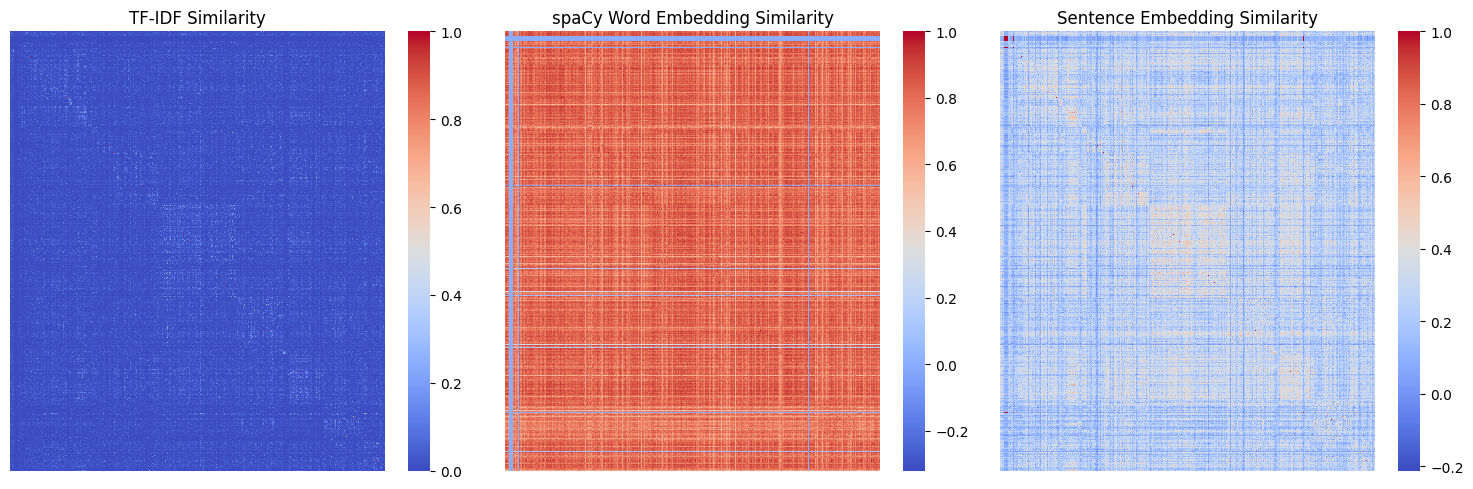

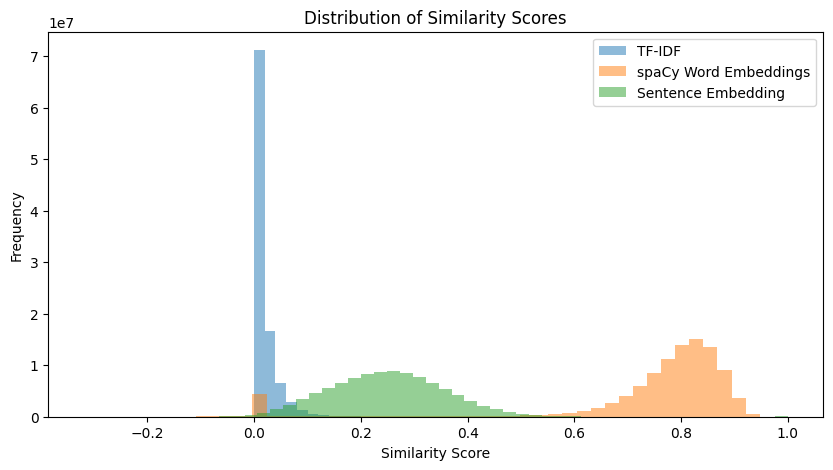

In [17]:
# Step 3: Comparative Analysis

# Plotting heatmaps for each similarity matrix
plt.figure(figsize=(15, 5))

## TF-IDF Similarity Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(tfidf_similarity, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("TF-IDF Similarity")

## spaCy Word Embeddings Similarity Heatmap
plt.subplot(1, 3, 2)
sns.heatmap(spacy_similarity, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("spaCy Word Embedding Similarity")

## Sentence Embeddings Similarity Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(sentence_similarity, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Sentence Embedding Similarity")

plt.tight_layout()
plt.show()

# Optional: Display similarity score distributions
plt.figure(figsize=(10, 5))
plt.hist(tfidf_similarity.flatten(), bins=50, alpha=0.5, label='TF-IDF')
plt.hist(spacy_similarity.flatten(), bins=50, alpha=0.5, label='spaCy Word Embeddings')
plt.hist(sentence_similarity.flatten(), bins=50, alpha=0.5, label='Sentence Embedding')
plt.legend(loc='upper right')
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


In [18]:
# Calculate the average similarity score for each method
tfidf_avg_similarity = np.mean(tfidf_similarity)
spacy_avg_similarity = np.mean(spacy_similarity)
sentence_avg_similarity = np.mean(sentence_similarity)

print("Average Similarity Scores:")
print(f"TF-IDF: {tfidf_avg_similarity:.4f}")
print(f"spaCy Word Embeddings: {spacy_avg_similarity:.4f}")
print(f"Sentence Embeddings: {sentence_avg_similarity:.4f}")

Average Similarity Scores:
TF-IDF: 0.0166
spaCy Word Embeddings: 0.7460
Sentence Embeddings: 0.2508


### TF-IDF (0.0166):
- A low average similarity score with TF-IDF suggests that this method finds most descriptions to be distinct. This is common with TF-IDF, as it’s highly sensitive to unique terms in each description without capturing deeper semantic similarity.

### spaCy Word Embeddings (0.7460):
- A high average similarity score with spaCy indicates that it interprets the descriptions as more semantically similar overall. Word embeddings capture word-level context well but may “over-generalize,” making unrelated texts appear more similar.

### Sentence Embeddings (0.2508):
- Sentence Embeddings provide an intermediate average similarity score, suggesting they balance capturing shared context without over-generalizing. Sentence embeddings typically perform better for sentence or paragraph-level similarities by understanding overall semantic meaning.


## Next, we create a small function to test these out 



In [19]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Function to get top 10 similar companies based on a description
def get_top_similar_companies(description, method='sentence', top_n=10):
    # Preprocess the input description
    description_cleaned = preprocess_text(description)
    
    # Convert to vector based on selected method
    if method == 'tfidf':
        description_vec = tfidf_vectorizer.transform([description_cleaned])
        similarity_scores = cosine_similarity(description_vec, tfidf_matrix)
    elif method == 'spacy':
        description_vec = get_spacy_vector(description_cleaned).reshape(1, -1)
        similarity_scores = cosine_similarity(description_vec, spacy_matrix)
    elif method == 'sentence':
        description_vec = sentence_model.encode([description_cleaned])
        similarity_scores = cosine_similarity(description_vec, sentence_embeddings)
    else:
        raise ValueError("Method should be 'tfidf', 'spacy', or 'sentence'")
    
    # Get top N indices of similar companies
    top_indices = similarity_scores[0].argsort()[-top_n:][::-1]
    
    # Retrieve and display top N similar rows
    similar_companies = data_cleaned.iloc[top_indices]
    similar_companies['Similarity Score'] = similarity_scores[0][top_indices]
    
    return similar_companies[['Name', 'Description', 'Similarity Score']]

In [20]:
# Save the cleaned data into a new Excel file
output_file_path = 'cleaned_data.xlsx'
data_cleaned.to_excel(output_file_path, index=False)

print(f"Cleaned data has been saved to {output_file_path}")

Cleaned data has been saved to cleaned_data.xlsx


In [21]:
# Example usage
sample_description = "Equal Ventures is a venture capital firm that ..."
top_similar = get_top_similar_companies(sample_description, method='sentence')


In [22]:
for i,j in enumerate(top_similar["Description"].values):
    print("Company no. :", i," Description : ",j)

Company no. : 0  Description :  Teamworthy Ventures is a venture capital firm based in New York City. They seek to develop long-term relationships with talented and trustworthy entrepreneurs and teams, and invest in their ventures at the seed, early, or growth stage. Their mission is...
Company no. : 1  Description :  Industry Ventures is a leading investment firm that focuses on venture capital. The firm has three investment strategies: secondary investments, primary fund of funds investments and direct co investments. Founded in 2000, the firm manages over $3 bill...
Company no. : 2  Description :  Equal Ventures is a venture capital firm that focuses on bridging the digital divide. They believe in interdisciplinary approaches and seek out perspectives across asset classes and stakeholders. They emphasize the importance of learning from past expe...
Company no. : 3  Description :  Vertica Capital Partners is a venture capital and private equity firm that specializes in investing in g

In [23]:
import pickle

# Save TF-IDF matrix
with open("tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

# Save spaCy matrix
with open("spacy_matrix.pkl", "wb") as f:
    pickle.dump(spacy_matrix, f)

# Save Sentence Embeddings matrix
with open("sentence_embeddings.pkl", "wb") as f:
    pickle.dump(sentence_embeddings, f)
    
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)